1. PatchEmbedding
2. IsometricEmbedding
3. Conv1dEmbedding(KernelSize 1)
4. Conv1dEmbedding(KernelSize seq_len)

In transformer-based time-series analysis, patch embedding could reduce the time computation.However,in ModernTCN it still uses patch-embedding with relatively small kernel size. To find whether patch embedding can affect the performance of the model, we set four experiments with different embedding methods. The first one is a common method with kernel size 4 and  stride size 2, and padding (P-S) is added at the end of the sequence.  

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
from einops import rearrange

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()

P=4 S=2

epoch1,loss0.0019,train acc 0.813616,val acc 0.841
epoch2,loss0.0018,train acc 0.855968,val acc 0.866
epoch3,loss0.0017,train acc 0.869978,val acc 0.861
epoch4,loss0.0017,train acc 0.878855,val acc 0.881
epoch5,loss0.0017,train acc 0.886645,val acc 0.891
epoch6,loss0.0016,train acc 0.893562,val acc 0.898
epoch7,loss0.0016,train acc 0.899429,val acc 0.903
epoch8,loss0.0016,train acc 0.903093,val acc 0.908
epoch9,loss0.0016,train acc 0.908732,val acc 0.904
epoch10,loss0.0016,train acc 0.912807,val acc 0.912
epoch11,loss0.0015,train acc 0.917014,val acc 0.917
epoch12,loss0.0015,train acc 0.921376,val acc 0.920
epoch13,loss0.0015,train acc 0.923512,val acc 0.925
epoch14,loss0.0015,train acc 0.924731,val acc 0.924
epoch15,loss0.0015,train acc 0.928116,val acc 0.931
epoch16,loss0.0015,train acc 0.930613,val acc 0.915
epoch17,loss0.0015,train acc 0.933087,val acc 0.934
epoch18,loss0.0015,train acc 0.934996,val acc 0.937
epoch19,loss0.0015,train acc 0.934849,val acc 0.939
epoch20,loss0.0015,tr

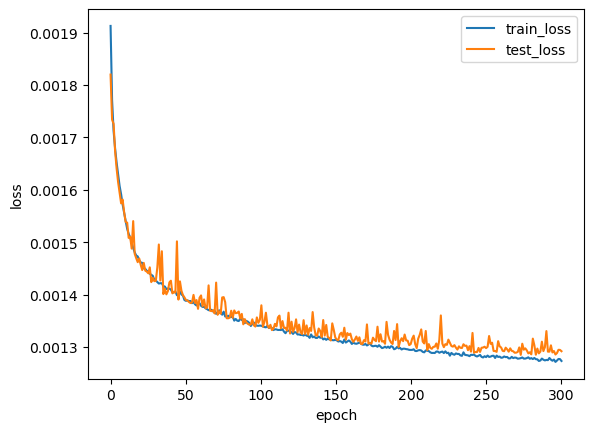

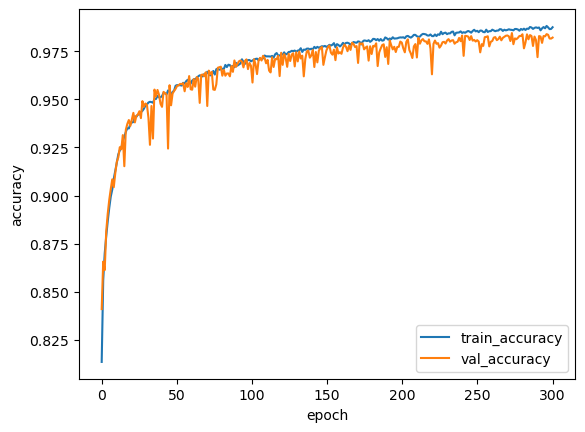

Accuracy on test set : 0.984
test precision: 0.9810781890261425  test recall: 0.9804754842829867  test f1_score: 0.9806799668460737


In [7]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=4,S=2):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        zeros = torch.zeros((x.shape[0], x.shape[1], self.P-self.S),device='cuda')
        x = torch.cat((x, zeros), dim=-1) #padding on the last 27
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=variable_dim*seq_len*channel_dim//4),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em1_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em1_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=8 S=4

epoch1,loss0.0020,train acc 0.794180,val acc 0.820
epoch2,loss0.0018,train acc 0.836319,val acc 0.847
epoch3,loss0.0018,train acc 0.856768,val acc 0.861
epoch4,loss0.0017,train acc 0.867165,val acc 0.868
epoch5,loss0.0017,train acc 0.875242,val acc 0.878
epoch6,loss0.0017,train acc 0.882020,val acc 0.881
epoch7,loss0.0017,train acc 0.885940,val acc 0.886
epoch8,loss0.0016,train acc 0.889377,val acc 0.889
epoch9,loss0.0016,train acc 0.891682,val acc 0.889
epoch10,loss0.0016,train acc 0.896947,val acc 0.895
epoch11,loss0.0016,train acc 0.900163,val acc 0.902
epoch12,loss0.0016,train acc 0.903607,val acc 0.906
epoch13,loss0.0016,train acc 0.907660,val acc 0.909
epoch14,loss0.0016,train acc 0.909723,val acc 0.911
epoch15,loss0.0016,train acc 0.914092,val acc 0.916
epoch16,loss0.0015,train acc 0.916647,val acc 0.917
epoch17,loss0.0015,train acc 0.919114,val acc 0.921
epoch18,loss0.0015,train acc 0.921332,val acc 0.925
epoch19,loss0.0015,train acc 0.925062,val acc 0.926
epoch20,loss0.0015,tr

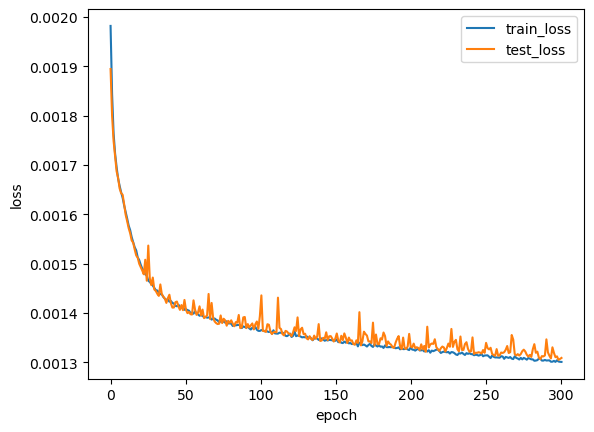

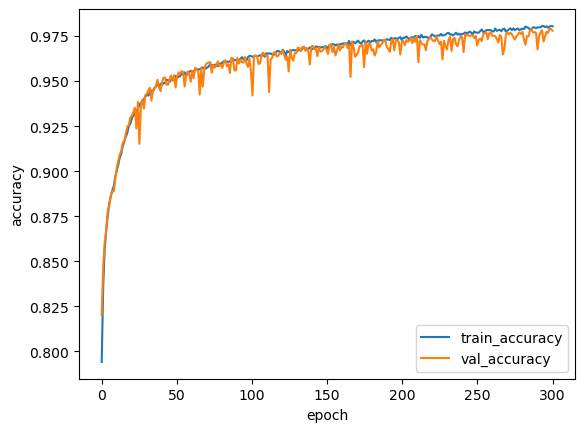

Accuracy on test set : 0.979
test precision: 0.9713087761991275  test recall: 0.9776065754534979  test f1_score: 0.9743191678234915


In [8]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=8,S=4):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        zeros = torch.zeros((x.shape[0], x.shape[1], self.P-self.S),device='cuda')
        x = torch.cat((x, zeros), dim=-1) #padding on the last 27
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=variable_dim*seq_len*channel_dim//8),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//8,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em2_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em2_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=2 S=1

epoch1,loss0.0019,train acc 0.802360,val acc 0.815
epoch2,loss0.0018,train acc 0.854859,val acc 0.881
epoch3,loss0.0017,train acc 0.885441,val acc 0.885
epoch4,loss0.0016,train acc 0.900750,val acc 0.904
epoch5,loss0.0016,train acc 0.908188,val acc 0.913
epoch6,loss0.0015,train acc 0.914855,val acc 0.921
epoch7,loss0.0015,train acc 0.921662,val acc 0.929
epoch8,loss0.0015,train acc 0.926831,val acc 0.933
epoch9,loss0.0015,train acc 0.930378,val acc 0.927
epoch10,loss0.0015,train acc 0.933528,val acc 0.933
epoch11,loss0.0015,train acc 0.936377,val acc 0.941
epoch12,loss0.0015,train acc 0.935892,val acc 0.934
epoch13,loss0.0015,train acc 0.940202,val acc 0.940
epoch14,loss0.0014,train acc 0.941311,val acc 0.930
epoch15,loss0.0014,train acc 0.942934,val acc 0.946
epoch16,loss0.0014,train acc 0.944461,val acc 0.944
epoch17,loss0.0014,train acc 0.945775,val acc 0.944
epoch18,loss0.0014,train acc 0.946597,val acc 0.948
epoch19,loss0.0014,train acc 0.948859,val acc 0.942
epoch20,loss0.0014,tr

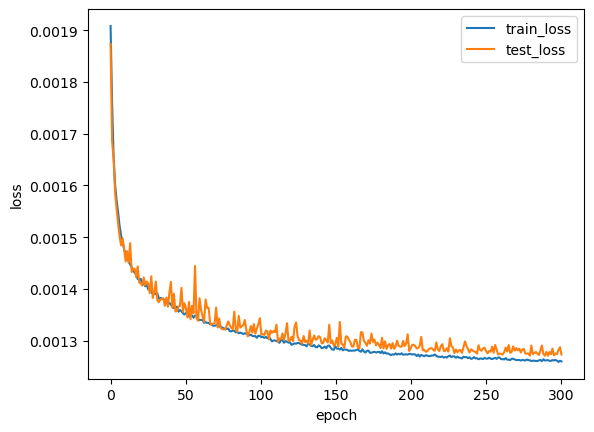

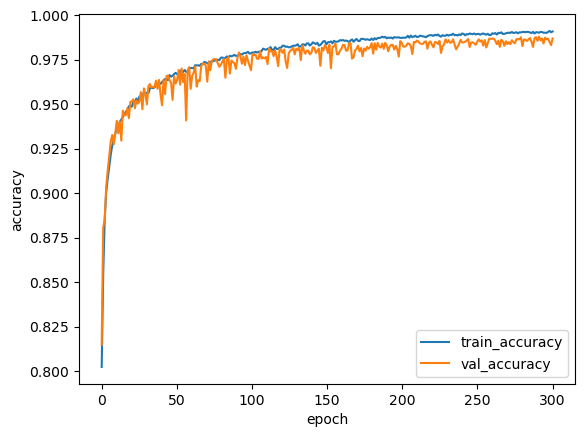

Accuracy on test set : 0.987
test precision: 0.9804237909709032  test recall: 0.9883085578271428  test f1_score: 0.9842882987983385


In [10]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=2,S=1):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        zeros = torch.zeros((x.shape[0], x.shape[1], self.P-self.S),device='cuda')
        x = torch.cat((x, zeros), dim=-1) #padding on the last 27
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em3_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em3_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=4 S=4

epoch1,loss0.0020,train acc 0.788549,val acc 0.816
epoch2,loss0.0019,train acc 0.831745,val acc 0.848
epoch3,loss0.0018,train acc 0.855483,val acc 0.860
epoch4,loss0.0017,train acc 0.867511,val acc 0.867
epoch5,loss0.0017,train acc 0.878840,val acc 0.881
epoch6,loss0.0017,train acc 0.885191,val acc 0.887
epoch7,loss0.0016,train acc 0.890735,val acc 0.889
epoch8,loss0.0016,train acc 0.895368,val acc 0.898
epoch9,loss0.0016,train acc 0.899774,val acc 0.899
epoch10,loss0.0016,train acc 0.904480,val acc 0.906
epoch11,loss0.0016,train acc 0.908306,val acc 0.906
epoch12,loss0.0016,train acc 0.911184,val acc 0.914
epoch13,loss0.0015,train acc 0.915325,val acc 0.915
epoch14,loss0.0015,train acc 0.918204,val acc 0.919
epoch15,loss0.0015,train acc 0.920781,val acc 0.921
epoch16,loss0.0015,train acc 0.923087,val acc 0.922
epoch17,loss0.0015,train acc 0.925363,val acc 0.925
epoch18,loss0.0015,train acc 0.927624,val acc 0.929
epoch19,loss0.0015,train acc 0.928601,val acc 0.931
epoch20,loss0.0015,tr

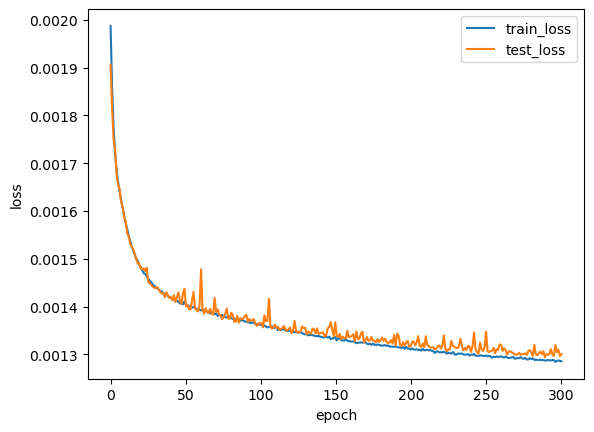

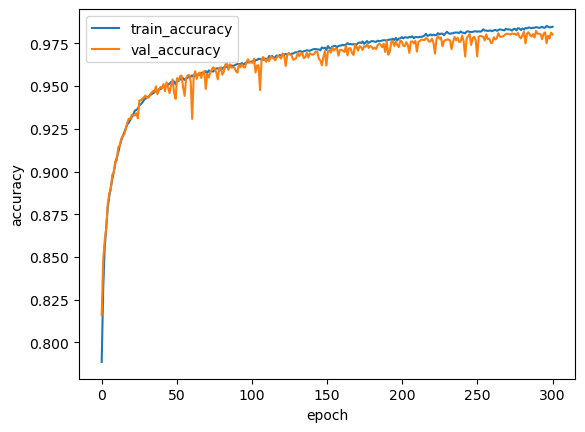

Accuracy on test set : 0.983
test precision: 0.9802876927049005  test recall: 0.9785292371535596  test f1_score: 0.9792942427581068


In [11]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=4,S=4):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=variable_dim*seq_len*channel_dim//8),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//8,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em4_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em4_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=2 S=2

epoch1,loss0.0019,train acc 0.804680,val acc 0.838
epoch2,loss0.0018,train acc 0.856974,val acc 0.872
epoch3,loss0.0017,train acc 0.874714,val acc 0.872
epoch4,loss0.0017,train acc 0.887321,val acc 0.888
epoch5,loss0.0016,train acc 0.893577,val acc 0.897
epoch6,loss0.0016,train acc 0.899377,val acc 0.903
epoch7,loss0.0016,train acc 0.903827,val acc 0.907
epoch8,loss0.0016,train acc 0.908379,val acc 0.907
epoch9,loss0.0016,train acc 0.910604,val acc 0.915
epoch10,loss0.0016,train acc 0.912851,val acc 0.912
epoch11,loss0.0015,train acc 0.916552,val acc 0.908
epoch12,loss0.0015,train acc 0.917624,val acc 0.916
epoch13,loss0.0015,train acc 0.921398,val acc 0.922
epoch14,loss0.0015,train acc 0.921691,val acc 0.923
epoch15,loss0.0015,train acc 0.926134,val acc 0.925
epoch16,loss0.0015,train acc 0.927257,val acc 0.927
epoch17,loss0.0015,train acc 0.928094,val acc 0.927
epoch18,loss0.0015,train acc 0.929408,val acc 0.930
epoch19,loss0.0015,train acc 0.929665,val acc 0.932
epoch20,loss0.0015,tr

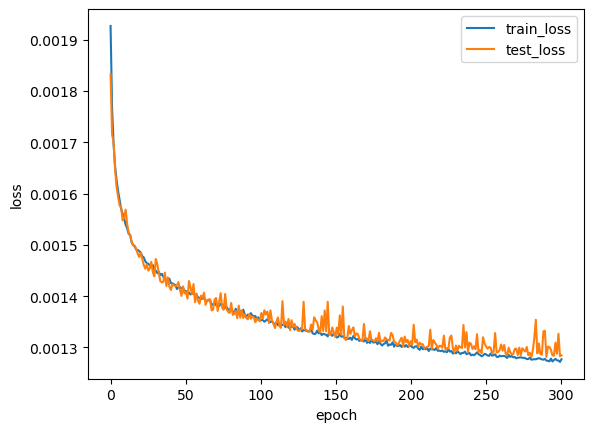

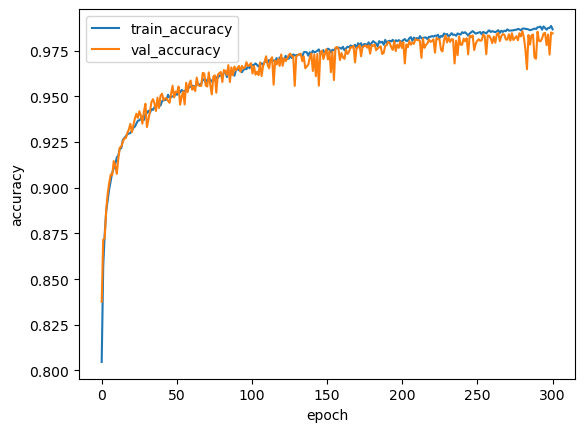

Accuracy on test set : 0.985
test precision: 0.9800535534986418  test recall: 0.983562881644557  test f1_score: 0.9817145279183579


In [13]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=2,S=2):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=variable_dim*seq_len*channel_dim//4),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//4,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em5_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em5_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

P=1 S=1

epoch1,loss0.0019,train acc 0.797433,val acc 0.810
epoch2,loss0.0018,train acc 0.840644,val acc 0.857
epoch3,loss0.0017,train acc 0.878936,val acc 0.882
epoch4,loss0.0016,train acc 0.893584,val acc 0.898
epoch5,loss0.0016,train acc 0.905413,val acc 0.908
epoch6,loss0.0016,train acc 0.913828,val acc 0.916
epoch7,loss0.0015,train acc 0.922727,val acc 0.925
epoch8,loss0.0015,train acc 0.928035,val acc 0.932
epoch9,loss0.0015,train acc 0.932727,val acc 0.940
epoch10,loss0.0015,train acc 0.936266,val acc 0.926
epoch11,loss0.0015,train acc 0.937206,val acc 0.939
epoch12,loss0.0014,train acc 0.942023,val acc 0.939
epoch13,loss0.0014,train acc 0.941972,val acc 0.937
epoch14,loss0.0014,train acc 0.944321,val acc 0.947
epoch15,loss0.0014,train acc 0.945092,val acc 0.941
epoch16,loss0.0014,train acc 0.947493,val acc 0.951
epoch17,loss0.0014,train acc 0.946752,val acc 0.945
epoch18,loss0.0014,train acc 0.950159,val acc 0.954
epoch19,loss0.0014,train acc 0.948852,val acc 0.942
epoch20,loss0.0014,tr

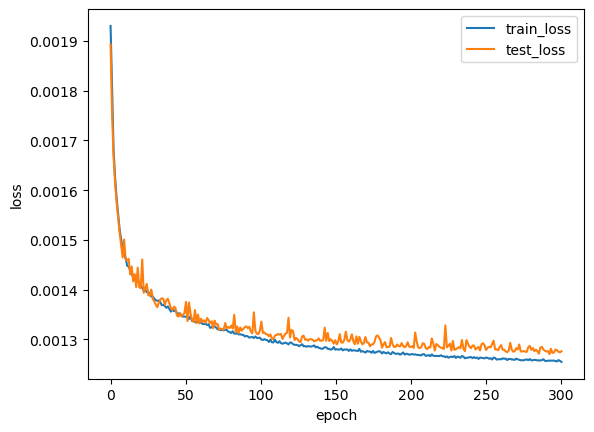

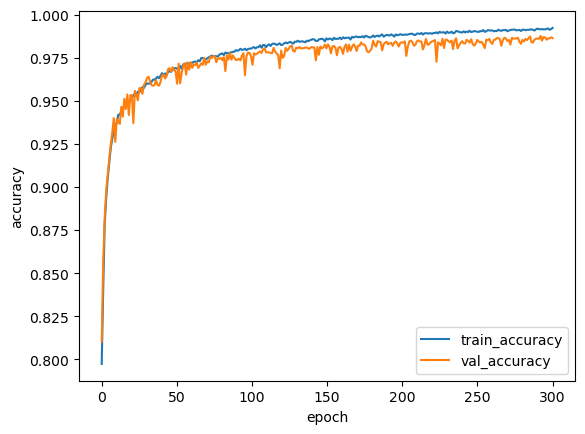

Accuracy on test set : 0.987
test precision: 0.9841598694614944  test recall: 0.9853141426601316  test f1_score: 0.9846588023184732


In [14]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim,P=1,S=1):
        super(Embedding,self).__init__()
        self.P = P
        self.S = S
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=P,padding=0,stride=S,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        #print("x:",x.shape) #256 3 6 50
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_em6_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_em6_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)